# ANNDL: 1st challenge


## ⚙️ Import Libraries
Import the libraries needed for the project and fix the seed for repeatability.

In [1]:
import numpy as np
import random

import gc
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

seed = 42
input_img_size = 96

np.random.seed(seed)
tf.random.set_seed(seed)

## ⏳ Load the Data

The data are loaded from the filtered, pre-processed data. For more details, see '''Preprocessing.ipynb''' notebook.

In [2]:
filtered_dataset_path = '../Preprocessing/balanced_dataset.npz'
data = np.load(filtered_dataset_path)
print(len(data['images']))
N=int(len(data['images']) * 8/10)
print(N)
X_train = data['images'][:N]
y_train = data['labels'][:N]


# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

18640
14912


In [3]:
# Normalize the data to the range [0, 1] and encode output labels
X_train = (X_train / 255).astype('float32')
y_train = tfk.utils.to_categorical(y_train, num_classes=len(unique_labels))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=seed, stratify=y_train)
print(f'Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}')
print(f'Training labels shape: {y_train.shape}, Validation labels shape: {y_val.shape}')

Training data shape: (10438, 96, 96, 3), Validation data shape: (4474, 96, 96, 3)
Training labels shape: (10438, 8), Validation labels shape: (4474, 8)


## 🔆 Augmenting the training and validation set
We use AutoContrast and RandomSaturation from the keras library for the training set. It enhances contrast adaptively and may help in highlighting subtle differences between cell types without altering structure. 
We added the agumented images to the training set & we applied some rotation, zoom and shift.

We use RandAugment for the validation set. 

In [4]:
# Import keras
import keras_cv as kcv

c:\Users\motti\Documents\ANNDL\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


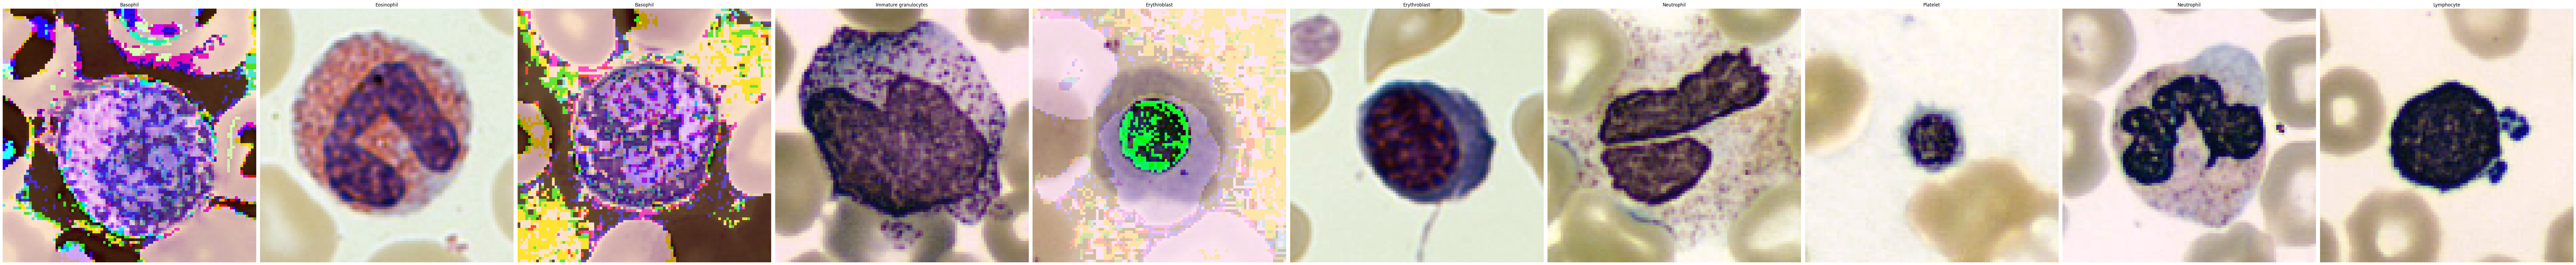

In [5]:
# Implement AutoContrast
value_range = [0, 1]
autocontrast = kcv.layers.AutoContrast(value_range)
contrast_result = autocontrast({'images': X_train, 'labels': y_train})

# Show some images
num_img = 10
random_indices = random.sample(range(len(contrast_result["images"])), num_img)
fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(contrast_result["images"][idx]), vmin=0., vmax=1.)
    # Get the index of the maximum value (representing the predicted class)
    label_index = np.argmax(contrast_result["labels"][idx])
    ax.set_title(labels[label_index])
    ax.axis('off')

plt.tight_layout()
plt.show()



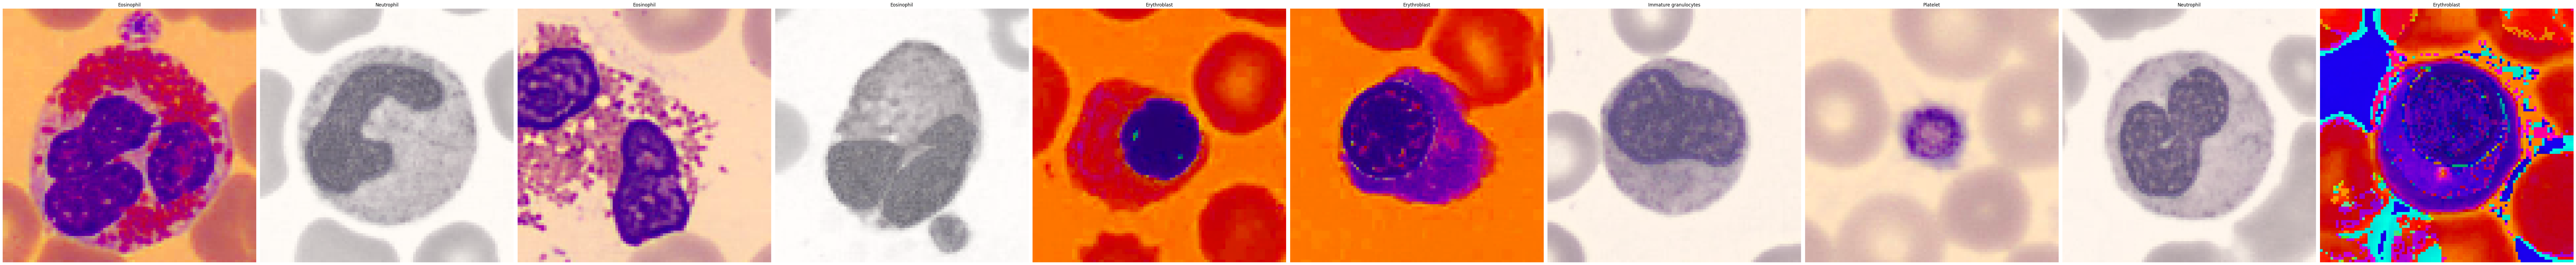

In [6]:
# Implement RandomSaturation
factor = [0, 1]
randomsaturation = kcv.layers.RandomSaturation(factor, seed=seed)
saturation_result = randomsaturation({'images': X_train, 'labels': y_train})

# Show some images
num_img = 10
random_indices = random.sample(range(len(saturation_result["images"])), num_img)
fig, axes = plt.subplots(1, num_img, figsize=(input_img_size, input_img_size))

for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(saturation_result["images"][idx]), vmin=0., vmax=1.)
    # Get the index of the maximum value (representing the predicted class)
    label_index = np.argmax(saturation_result["labels"][idx])
    ax.set_title(labels[label_index])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Implement Solarization
value_range = [0, 1]
solar = kcv.layers.Solarization(value_range)
sol_result = solar({'images': X_train, 'labels': y_train})


In [8]:
X_train = np.concatenate((X_train, contrast_result["images"]), axis=0)
y_train = np.concatenate((y_train, contrast_result["labels"]), axis=0)

del contrast_result
gc.collect()

X_train = np.concatenate((X_train, saturation_result["images"]), axis=0)
y_train = np.concatenate((y_train, saturation_result["labels"]), axis=0)

del saturation_result
gc.collect() 

X_train = np.concatenate((X_train, sol_result["images"]), axis=0)
y_train = np.concatenate((y_train, sol_result["labels"]), axis=0)

del sol_result
gc.collect()

0

In [9]:
# Augmenting validation set
randaugment = kcv.layers.RandAugment(value_range=(0,1), augmentations_per_image=3, magnitude=0.3)
val_augmented = randaugment(X_val)
print("val_agumented shape:", val_augmented.shape)
print("y_val shape:", y_val.shape)

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,         # Equivalent to RandomRotation
    width_shift_range=0.2,     # Equivalent to RandomTranslation on x-axis
    height_shift_range=0.2,    # Equivalent to RandomTranslation on y-axis
    zoom_range=0.2,            # Equivalent to RandomZoom
    horizontal_flip=True,      # Equivalent to RandomFlip (horizontal)
    vertical_flip=True         # Equivalent to RandomFlip (vertical)
)

train_generator = datagen.flow(X_train, y_train)

In [ ]:
# Save in .zip file training and validation set
#np.savez_compressed('solar_dataset', images_t=X_train, labels_t=y_train, images_v = val_augmented, labels_v = y_val)

## Transfer Learning

In [ ]:
# Initialise densenet model with pretrained weights, for transfer learning
dense = tfk.applications.densenet.DenseNet121(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling=None,
    classifier_activation='softmax'
)

# Display a summary of the model architecture
# dense.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(dense, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Freeze all layers in DenseNet to use it solely as a feature extractor
dense.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Pass inputs through the feature extractor
x = dense(inputs)

# Add a Global Average Pooling layer to flatten the spatial dimensions
x = tfkl.GlobalAveragePooling2D(name='global_avg_pool')(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
optimizer = tfk.optimizers.Lion()
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

# Display a summary of the model architecture
# tl_model.summary(expand_nested=True)

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=4,
    restore_best_weights=True)

reduce_lr_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=5
    )

callbacks = [early_stopping, reduce_lr_on_plateau]

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_generator,
    batch_size=16,
    epochs=3,
    validation_data=(val_augmented, y_val),
    callbacks=callbacks
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'TL_dense_' + str(final_val_accuracy) + '.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

## Fine Tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model(model_filename)

In [ ]:
ft_model.get_layer('densenet121').trainable = True

# Set all DenseNet121 layers as non-trainable
for layer in ft_model.get_layer('densenet121').layers:
    layer.trainable = False

# Enable training only for Conv2D layers
for i, layer in enumerate(ft_model.get_layer('densenet121').layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

In [ ]:
# Set the number of layers to freeze
N = 130

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('densenet121').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('densenet121').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
#ft_model.summary(expand_nested=True)

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    train_generator, 
    batch_size = 16,
    epochs = 6,
    validation_data = (val_augmented, y_val),
    callbacks = callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

## Evaluate and save the model

In [ ]:
# Load the saved model
model = tfk.models.load_model(model_filename)

# Compute the confusion matrix
predictions = model.predict(X_val)
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_val, axis=-1)
cm = confusion_matrix(true_classes, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, annot=True, fmt='', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# Plot the loss and accuracy metrics
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```


In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = X / 255.0
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
# Create the .zip file to be submitted
import os
import zipfile

# Check if model.py and weights.keras exist
if os.path.exists("model.py") and os.path.exists("weights.keras"):
    # Create a ZIP file containing model.py and weights.keras
    with zipfile.ZipFile("sub.zip", "w") as model_zip:
        model_zip.write("model.py")
        model_zip.write("weights.keras")
    print("model.zip has been created successfully.")
else:
    print("model.py or weights.keras not found. Please ensure both files are in the current directory.")